## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date'] = pd.to_datetime(data['date'])
print(data.groupby('group')['date'].min())
print(data.groupby('group')['date'].max())

group
A   2021-01-02
B   2021-01-02
Name: date, dtype: datetime64[ns]
group
A   2021-01-24
B   2021-01-24
Name: date, dtype: datetime64[ns]


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
print(data.groupby('group')['date'].count())
print(data.groupby('group')['purchase'].sum())
print(data.groupby('group')['price'].sum()/1e6)


group
A    147202
B    147276
Name: date, dtype: int64
group
A    17723
B    17514
Name: purchase, dtype: int64
group
A    1436.26
B    1554.10
Name: price, dtype: float64


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
data.head(2)

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0


In [7]:
set_a = set(data[data['group'] == 'A']['user_id'])
set_b = set(data[data['group'] == 'B']['user_id'])
common_users = set_a.intersection(set_b)
len(common_users)



1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [8]:
updated_data = data[data['user_id'].apply(lambda x: x not in common_users)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

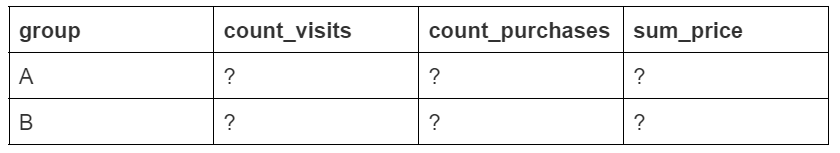
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [9]:
ab_data = updated_data.groupby('group').agg({
    'date': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).rename(columns={'date': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
ab_data

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

#### Выводы:
Суда из полученной выборки, мы видим, что данные  по посещениям и кол-ву покупок практически равны. Сумма покупок в группе B на 115 млн. больше чем в группе А. В целом мы можем назвать данную выборку сбалансированной. 

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [10]:
ab_data['convesrion'] = ((ab_data['count_purchases'] / ab_data['count_visits'])*100).round(2)
ab_data['mean_check'] = (ab_data['sum_price'] / ab_data['count_purchases']).round(2)
ab_data

,count_visits,count_purchases,sum_price,convesrion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.23
B,145381,17290,1533010000,11.89,88664.55


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Хоть конверсия в группы В немного ниже, но вот средний чек на 7.5 тыс. больше.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

In [11]:
pivot = updated_data.pivot_table(
    values = 'purchase', 
    index='group', 
    columns='price', 
    aggfunc='count'
)

pivot

price,0,10000,60000,100000,150000,200000
group,,,,,,
A,127820,5182,5271,1832,3478,1724
B,128091,5201,1730,5227,3438,1694


Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Из данной сводной таблицы мы видим, что по турам стоимостью 60тыс, 150тыс. и 200тыс. покупательская способность участников группы А выше. По турам стоимостью 60 тыс разница достигает почти в 3 раза, как по другим она очень не значительная, практически равна. 
В свою очередь покупательская способность участников группы В по турам стоимость. 100 тыс также болье практически в 3 раза. 

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [31]:
daily_data = updated_data.groupby(['date', 'group']).agg({
    'date': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).rename(columns={'date': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})

daily_data['convesrion'] = ((daily_data['count_purchases'] / daily_data['count_visits'])*100).round(2)
daily_data['mean_check'] = (daily_data['sum_price'] / daily_data['count_purchases']).round(2)
print(daily_data.loc['2021-01-03']['convesrion'])
print(daily_data.loc['2021-01-03']['mean_check'])

daily_data['cum_visits'] = daily_data.groupby('group')['count_visits'].cumsum()
daily_data['cum_purchases'] = daily_data.groupby('group')['count_purchases'].cumsum()
daily_data['cum_price'] = daily_data.groupby('group')['sum_price'].cumsum()


date        group
2021-01-03  A        11.34
            B        11.39
Name: convesrion, dtype: float64
date        group
2021-01-03  A        82887.70
            B        87480.11
Name: mean_check, dtype: float64


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [33]:
daily_data['cum_convesrion'] = ((daily_data['cum_purchases'] / daily_data['cum_visits'])*100).round(2)
daily_data['cum_mean_check'] = (daily_data['cum_price'] / daily_data['cum_purchases']).round(0)

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

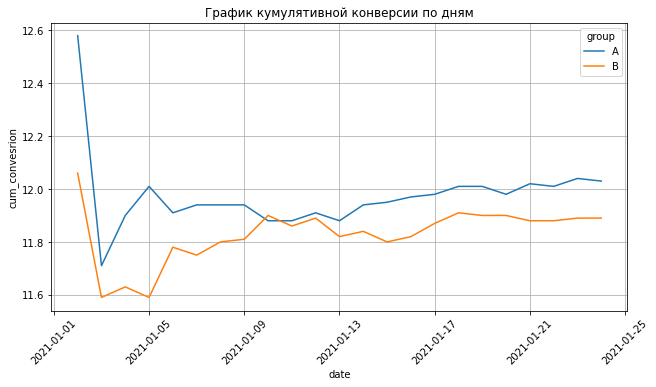

In [34]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,1,1,1])
sns.lineplot(data = daily_data, x = 'date', y = 'cum_convesrion', hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True)

Из даного графика мы видим, что начиная с 09.01.2021 значения метрик кумулятивной конверсии по дням стабилизировались. В целом метрики кумулятивной конверсии группы А выше чем в группе В. На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

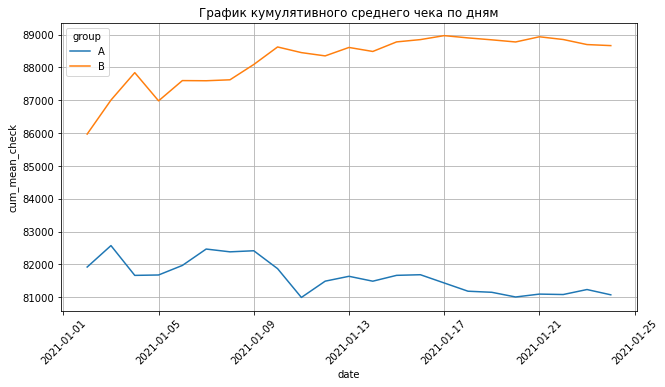

In [35]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,1,1,1])
sns.lineplot(data = daily_data, x = 'date', y = 'cum_mean_check', hue='group', ax=ax)
ax.set_title('График кумулятивного среднего чека по дням')
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True)

Здесь мы видим, что значения кумулятивного среднего чека стабилизировались с 05.01.2021 и здесь есть существенная разница в метриках. Метрики группы В значительно превышают метрики группы А, примерно на 6 тыс. 

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [40]:
ab_data

,count_visits,count_purchases,sum_price,convesrion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.23
B,145381,17290,1533010000,11.89,88664.55


In [42]:
H0 = 'Конверсии в группах А и В равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе В'
alpha = 0.05

_, p_value = proportions_ztest(
    count=ab_data['count_purchases'],
    nobs=ab_data['count_visits'],
    alternative='smaller'
)

print('p-value: ', round(p_value, 2))
if p_value < alpha:
    print(f'Отвергаем нулевую гипотезу. {H0}')
    print(f'Альтернативная гипотеза Н1. {H1}')
else: 
    print(f'Принимаем нулевую гипотезу. {H0}')

p-value:  0.88
Принимаем нулевую гипотезу. Конверсии в группах А и В равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Ми получили p-value = 0.88 и оно больше, чем заданные уровень значимости 0.05. Значит мы должны принять нулевую гипотезу о равенстве конверсий, так как разница в метриках в группах А и В не значима. 

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [48]:
updated_data

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0


In [50]:
def proportions_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5
    lower_bound = x_p - eps
    upper_bound = x_p + eps
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

a_data = updated_data[updated_data['group'] == 'A']
b_data = updated_data[updated_data['group'] == 'B']

conf_interval_a = proportions_conf_interval(
    n = a_data['user_id'].count(),
    x_p = a_data['purchase'].mean()
)

conf_interval_b = proportions_conf_interval(
    n = b_data['user_id'].count(),
    x_p = b_data['purchase'].mean()
)

print(f'Доверительный интервал для конверсии группы А: {conf_interval_a}')
print(f'Доверительный интервал для конверсии группы B: {conf_interval_b}')

n = [a_data['user_id'].count(), b_data['user_id'].count()]
x_p = [a_data['purchase'].mean(), b_data['purchase'].mean()]
alpha = 0.05
diff = x_p[1] - x_p[0]
z_crit = -norm.ppf(alpha/2)
eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5
lower_bound = diff - eps
upper_bound = diff + eps
print(f'Доверительный интервал для разности конверсий: {round(lower_bound * 100, 2), round(upper_bound * 100, 2)}')

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

По полученным нами данным можно сделать вывод, что с надежностью в 95% конверсия группы А лежит в интервале от 11ю87% до 12.2?, а конверсия группы В лежит в 
интервале от 11.73% до 12.06%. Также существует вероятность, что истинное значение конверсий в обеих группах может совпать (попасть в совместную зону между
11.87 и 12.06).

А исходя из данных по доверительному интервалу для разности конверсий мы можем сделать выводы, что статистической разницы в конверсии между вариантами груп А и В не существует, то есть они яляются равнозначными по данной метрике. 

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [64]:
H0 = 'Данные распределены нормально'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05

pivot = daily_data.pivot_table(
    values='mean_check',
    columns='group', 
    index='date'
)
pivot

_, p = shapiro(pivot)
print('p=%.3f' % p)

# Интерпретация 
if p > alpha:
	print(H0)
else:
	print(H1)

p=0.350
Данные распределены нормально


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [ ]:
# ваш код здесь

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [ ]:
ваши выводы здесь

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 